In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

import warnings
warnings.filterwarnings('ignore')

In [2]:
%cd ~/PycharmProjects/pqr/

from pqr.factors import PickingFactor, FilteringFactor, WeightingFactor
from pqr.factor_model import FactorModel
from pqr.benchmarks import Benchmark

from pqr.preprocessing import correct_matrices, replace_with_nan

/home/akbabkin/PycharmProjects/pqr


# Загрузка и предобработка данных

In [3]:
# загружаем цены
prices = pd.read_excel('~/notebooks/pqr/factors/monthlyprice.xlsx', index_col=0, parse_dates=True)
# загружаем данные по рыночной капитализации
mcap = pd.read_excel('~/notebooks/pqr/factors/mcap.xlsx', index_col=0, parse_dates=True)
# загружаем данные по среднему объему торгов за день
volume = pd.read_excel('~/notebooks/pqr/factors/betafilter.xlsx', index_col=0, parse_dates=True)
# загружаем бенчмарк
imoex = pd.read_excel('~/notebooks/pqr/factors/imoex.xlsx', index_col=0, parse_dates=True)

In [4]:
# приводим все таблицы к одинаковому формату
prices, mcap, volume = correct_matrices(prices, mcap, volume)

# убираем значения, обозначающие nan
prices, mcap, volume = replace_with_nan(prices, mcap, volume, to_replace=[0])

# Переходим к факторам

Факторы могут быть 3 видов:
* отбирающие - факторы, на основе которых ведется отбор бумаг в портфель
* фильтрующие - факторы, предварительно "сжимающие" множество доступных акций на основе порогов по своим значениям
* взвешивающие - факторы, значения которых используются для расчета весов бумаг в портфелях

Каждый из видов факторов имеет свой отдельный класс.

In [5]:
# основной фактор для отбора бумаг
size = PickingFactor(
    data=mcap,
    dynamic=False,
    bigger_better=False,
    name='size'
)

# фильтрующий фактор 
liquidity = FilteringFactor(
    data=volume,
    dynamic=False,
    min_threshold=10_000_000,
    name='liquidity_filter'
)

Бенчмарком можно и не пользоваться: тогда он будет построен автоматически на основе всего множества акций (без фильтра), т.е. в каждый период бенчмарк будет состоять из всех доступных в этот период бумаг в равных весах. Можно и самостоятельно сделать подобный бенчмарк, в том числе со своим взвешивающим фактором с помощью класс CustomBenchmark (pqr.benchmarks).

In [6]:
# у нас есть индекс-бенчмарк, поэтому не будем заморачиваться
benchmark = Benchmark(imoex['IMOEX'], name='imoex')

# 1 способ использования: строим факторную модель

Данный способ хорошо подходит для первичного анализа фактора и научных исследований наличия факторов на том или ином рынке.

Сначала построим одну модель с параметрами 3-0-3

In [37]:
# инициализируем факторную модель и задаем параметры
fm = FactorModel(
    looking_period=3,
    lag_period=0,
    holding_period=3
)

# "обучаем" факторную модель
fm.fit(
    prices=prices,
    picking_factor=size,
    filtering_factor=liquidity,
    benchmark=benchmark,
    add_wml=True,
    n_quantiles=3
)

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))",WMLPortfolio()
"Alpha, %",-0.07,-0.05,-0.09,0.02
Alpha p-value,0.83,0.87,0.50,0.96
Beta,1.08,0.96,0.98,0.11
Beta p-value,0.00,0.00,0.00,0.02
Sharpe Ratio,0.48,0.48,0.53,0.11
"Mean Return, %",1.24,1.10,1.09,0.15
"Excessive Return, %",-0.07,-0.20,-0.21,-1.16
"Total Return, %",456.94,412.27,458.26,7.07
"Volatility, %",8.93,7.88,7.08,4.78
Benchmark Correlation,0.84,0.84,0.95,0.16


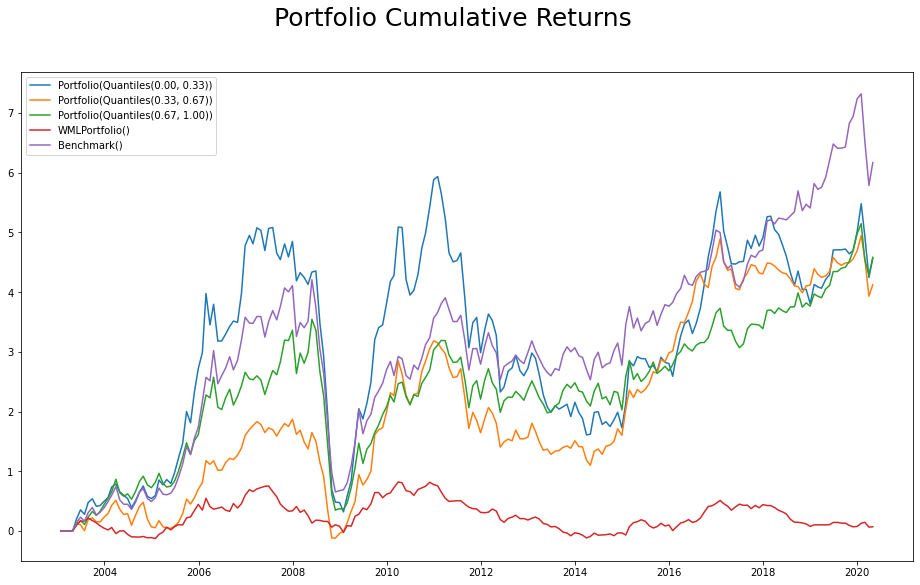

In [38]:
fm.compare_portfolios()

## Поищем модель получше

Результаты получились не очень: ни один портфель не победил бенчмарк. Скорее всего, параметры подобраны неправильно, но вручную перебирать их может быть довольно-таки трудозатратно. К тому же, есть риск пропустить хорошую модель.

Поэтому воспользуемся перебором параметров. Данный метод принимает все те же самые параметры, что и метод `fit`, но сначала необходимо передать списки значений для looking, lag и holding периодов.

In [9]:
%%time
%%capture

results = FactorModel.grid_search(
    looking_periods=[1, 3, 6, 9, 12],
    lag_periods=[0, 1],
    holding_periods=[1, 3, 6, 9, 12],
    prices=prices,
    picking_factor=size,
    filtering_factor=liquidity,
    benchmark=benchmark
)

CPU times: user 7.36 s, sys: 51.6 ms, total: 7.41 s
Wall time: 7.41 s


Теперь у нас есть словарь со статистикой для каждой модели. Посмотрим, что для нашей изначальной модели статистика все та же (с тем лишь исключением, что перебирали мы без WML-портфелей).

In [10]:
results[(3, 0, 3)]

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.07,-0.05,-0.09
Alpha p-value,0.83,0.87,0.50
Beta,1.08,0.96,0.98
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.48,0.48,0.53
"Mean Return, %",1.24,1.10,1.09
"Excessive Return, %",-0.07,-0.20,-0.21
"Total Return, %",456.94,412.27,458.26
"Volatility, %",8.93,7.88,7.08
Benchmark Correlation,0.84,0.84,0.95


На данный момент не реализован поиск лучшего портфеля по таргету, но его можно сделать самостоятельно довольно простой функцией. Найдем портфель с наибольшим коэффициентом Шарпа.

In [11]:
def find_best_model(results, target='Alpha, %'):
    model_params = None
    max_target = -np.inf
    best_portfolio = None
    for params, stats in results.items():
        max_value = stats.loc[target].max()
        if max_value > max_target:
            model_params = params
            best_portfolio = stats.columns[stats.loc[target].argmax()]
            max_target = max_value
    return model_params, best_portfolio

In [12]:
find_best_model(results, target='Sharpe Ratio')

((1, 0, 1), 'Portfolio(Quantiles(0.33, 0.67))')

У нас получилось, что лучшая модель имеет параметры 1-0-1, а портфель состоит из квантилей от 1/3 до 2/3. Построим такую модель.

In [35]:
fm = FactorModel(1, 0, 1)
fm.fit(
    prices=prices,
    picking_factor=size,
    filtering_factor=liquidity,
    benchmark=benchmark
)

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.53,0.42,-0.03
Alpha p-value,0.14,0.21,0.79
Beta,1.12,0.94,0.96
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.32,0.67,0.57
"Mean Return, %",0.87,1.60,1.17
"Excessive Return, %",-0.44,0.29,-0.14
"Total Return, %",137.08,1218.09,554.15
"Volatility, %",9.37,8.17,7.09
Benchmark Correlation,0.84,0.81,0.96


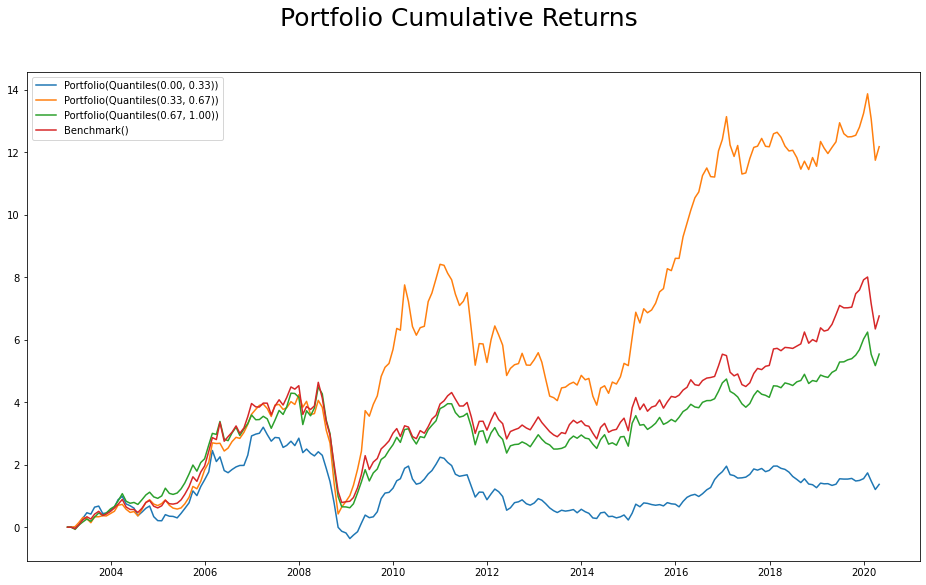

In [36]:
fm.compare_portfolios()

### Лучший портфель поподробнее

Шарп получился меньше 1, не очень впечатляет, но посмотрим поподробнее на данный портфель. После обучения модели все портфели сохраняются в кортеж, нас интересует 2 элемент.

In [15]:
best_portfolio = fm.portfolios[1]
best_portfolio

Portfolio(Quantiles(0.33, 0.67))

Посмотрим на изменение годовой беты портфеля: видно, что в основном бета колеблется около 1, но в последние годы снизилась почти на половину.

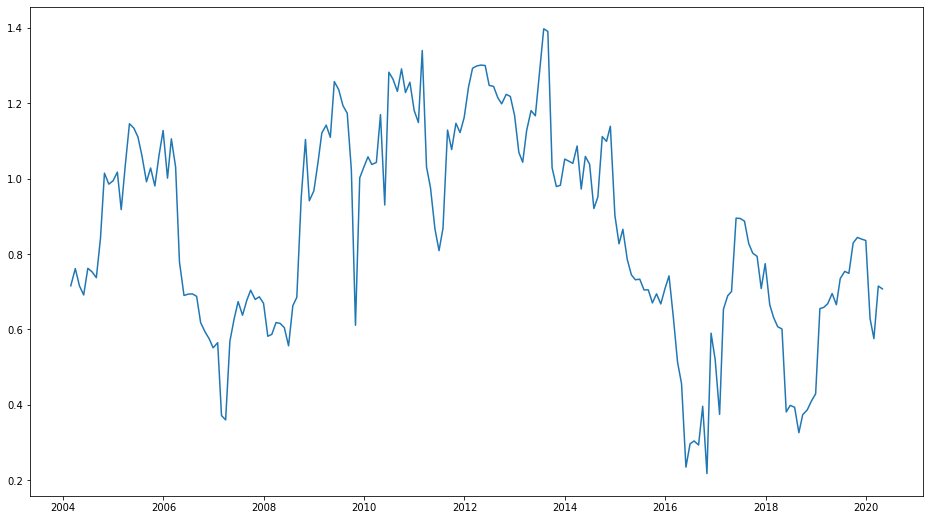

In [16]:
best_portfolio.plot_rolling_beta()

Годовой Шарп выглядит совсем непривлекательно - американские горки.

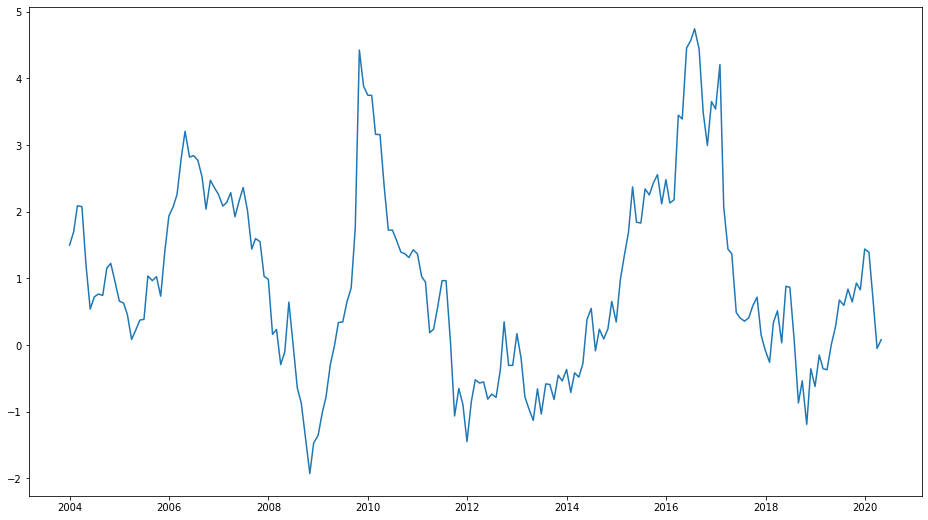

In [17]:
best_portfolio.plot_rolling_sharpe()

Годовая просадка в целом не так ужасно выглядит, но в 2008 падение стоило бы всего портфеля, и даже чуть больше, поэтому окончательно отметаем данный портфель.

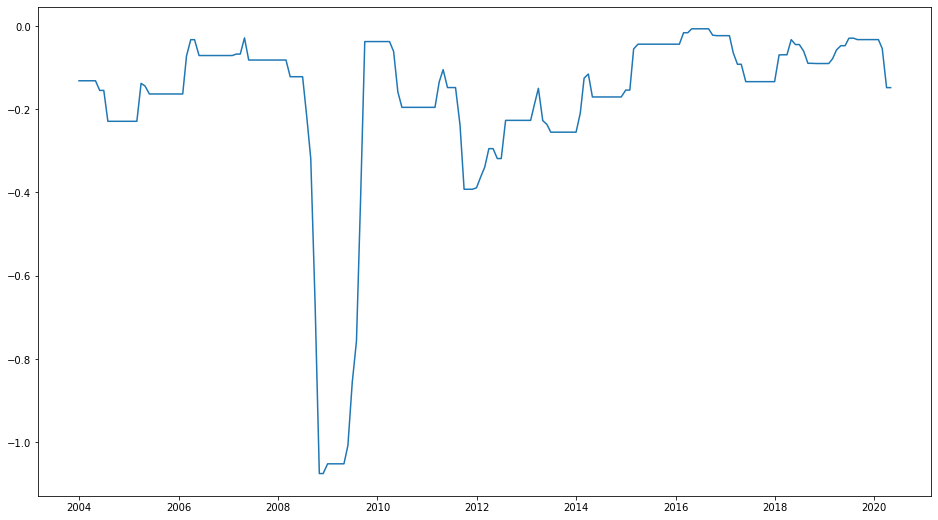

In [18]:
best_portfolio.plot_rolling_max_drawdown()

# 2 способ использования: строим и настраиваем портфель

В примере выше мы хотели рассмотреть всего 1 портфель, для этого нам не было необходимости строить еще 2 дополнительных. Но данная глава нужна не только для того, чтобы облегчить расчеты, иногда нас может интересовать конкретный портфель, и мы хотим сконцентрироваться на его настройке. Ну или требуется более подробно изучить фактор.

Но для этого придется чуть больше погрузиться в библиотеку.

In [19]:
from pqr.portfolios import Portfolio
from pqr.intervals import Quantiles, Thresholds, Top

In [20]:
# создадим 2 портфеля

# портфель, включающий в себя топ-10 акций по значению фактора
# для фактора размера это в действительности топ-10 худших компаний, т.е. топ-10 с наиболее высокой капитализацией
top_portfolio = Portfolio(Top(1, 10))

# портфель, включающий 10% бумаг с наименьшим значением фактора
q_portfolio = Portfolio(Quantiles(0, 1/10))

In [21]:
# проинвестируем в оба в стратегию 3-0-3
top_portfolio.invest(
    prices=prices,
    picking_factor=size,
    looking_period=3,
    lag_period=0,
    holding_period=3,
    filtering_factor=liquidity,
    benchmark=benchmark
)

q_portfolio.invest(
    prices=prices,
    picking_factor=size,
    looking_period=3,
    lag_period=0,
    holding_period=3,
    filtering_factor=liquidity,
    benchmark=benchmark
)

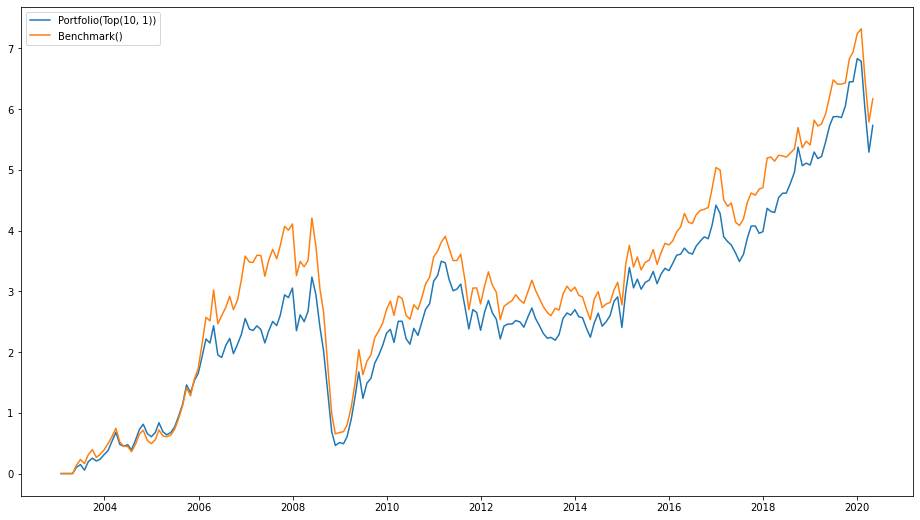

In [22]:
top_portfolio.plot_cumulative_returns()
plt.legend()

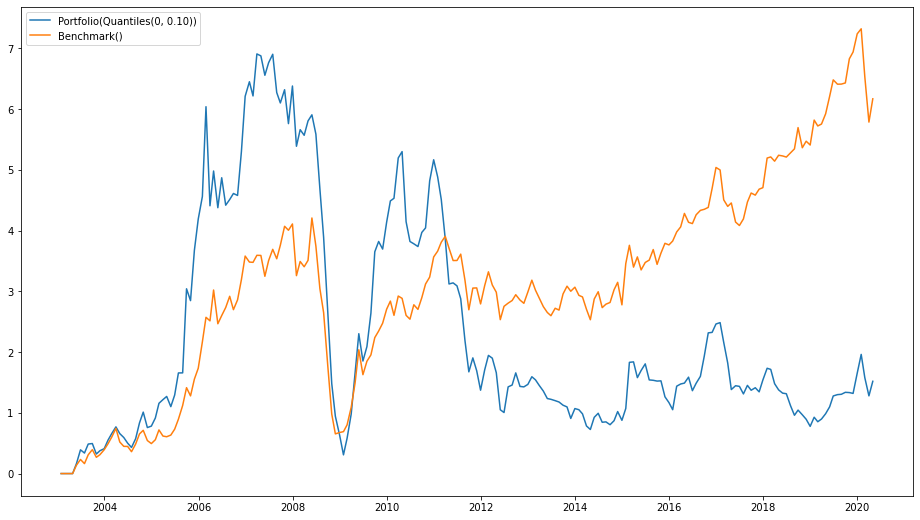

In [23]:
q_portfolio.plot_cumulative_returns()
plt.legend()

Получились интересные результаты: топ-10 компаний по капитализации почти полностью копируют индекс МосБиржи, но все-таки ему проигрывают. 10% компаний с наименьшей капитализацией неплохо смотрелись до 2008 года, и даже после него отскочили сильнее, чем индекс, но с 2012 они топчатся на месте.

Окей, возьмем в разработку портфель из топ-10 компаний по капитализации. Попробуем взвесить его по ней же, получится по сути своей смарт-бета портфель (за тем лишь исключением, что фактор размера мы используем в другую сторону:)).

In [24]:
size_w = WeightingFactor(
    data=mcap,
    dynamic=False,
    bigger_better=True
)

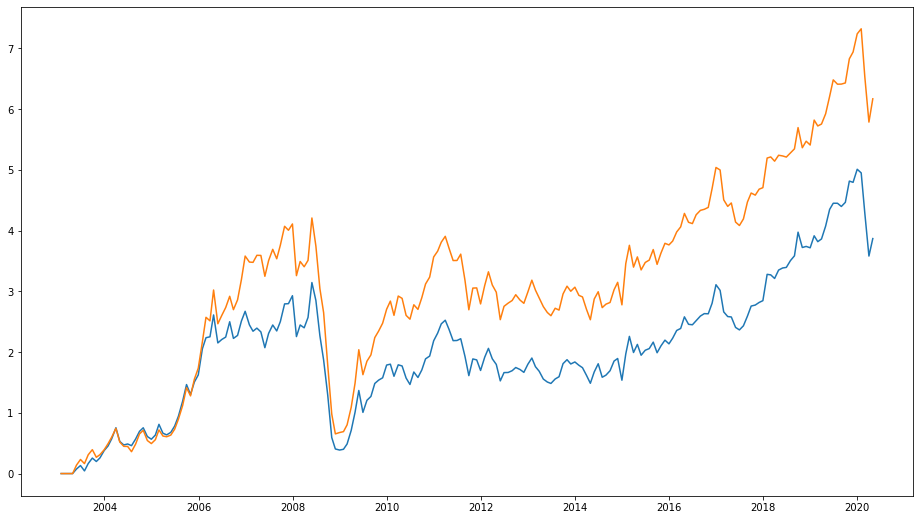

In [25]:
top_portfolio.invest(
    prices=prices,
    picking_factor=size,
    looking_period=3,
    lag_period=0,
    holding_period=3,
    filtering_factor=liquidity,
    weighting_factor=size_w,
    benchmark=benchmark
)

top_portfolio.plot_cumulative_returns()

Как бы это не выглядело странным, но после перехода от равных весов к взвешиванию по капитализации, портфель довольно сильно отстал от бенчмарка. Попробуем, наоборот (пока не реализовано взвешивание по факторам, для которых bigger_better=False, поэтому самостоятельно сделаем преобразование).

In [26]:
size_reversed_w = WeightingFactor(
    data=1/mcap,
    dynamic=False,
    bigger_better=True
)

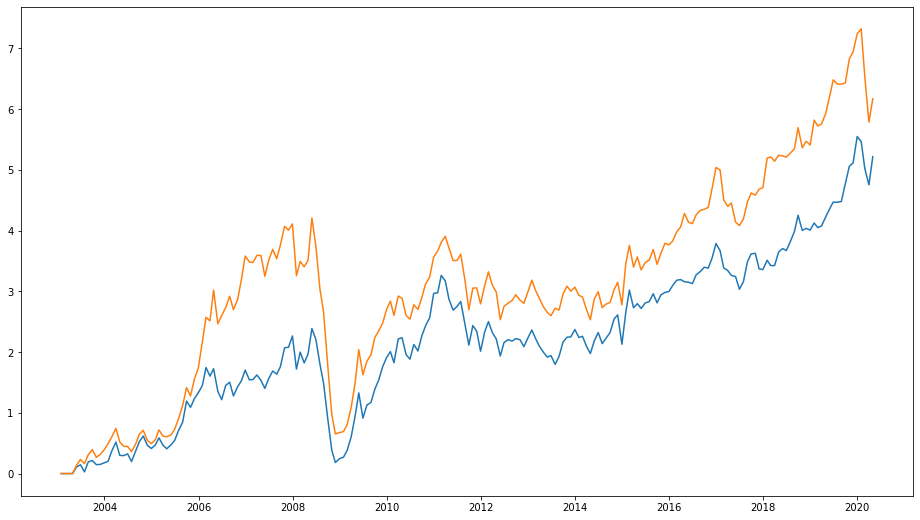

In [27]:
top_portfolio.invest(
    prices=prices,
    picking_factor=size,
    looking_period=3,
    lag_period=0,
    holding_period=3,
    filtering_factor=liquidity,
    weighting_factor=size_reversed_w,
    benchmark=benchmark
)

top_portfolio.plot_cumulative_returns()

Отставание от бенчмарка сократилось, но по-прежнему больше, чем при портфеле с равными весами. Обогнать бенчмарк на основе фактора размера на российском рынке не вышло, но это мы еще не пробовали другие параметры. Пока признаем поражение и посмотрим, что еще можно достать из портфеля.

## Немного аналитики по портфелю

Посмотрим, какие вообще компании в основном были в нашем портфеле. Абсолютными лидерами стали Сбербанк, Сургутнефтегаз, Норникель и Лукойл. Выглядит так, что они были в нашем портфеле вообще всегда.

<AxesSubplot:>

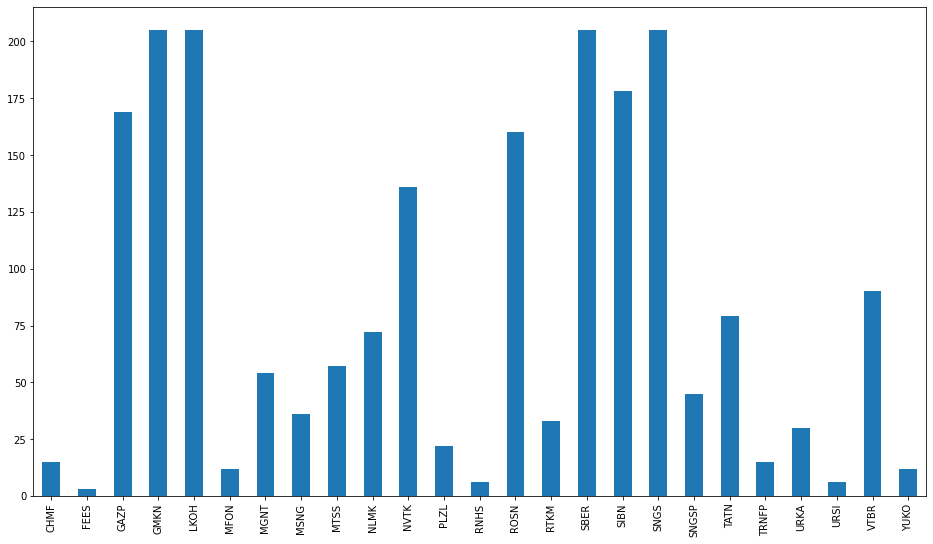

In [28]:
picks = top_portfolio.positions.sum()
picks[picks != 0].plot.bar()

По графику прибыльных периодов видно, что вероятность прибыльного периода колеблется около 50%, но чаще все-таки выше.

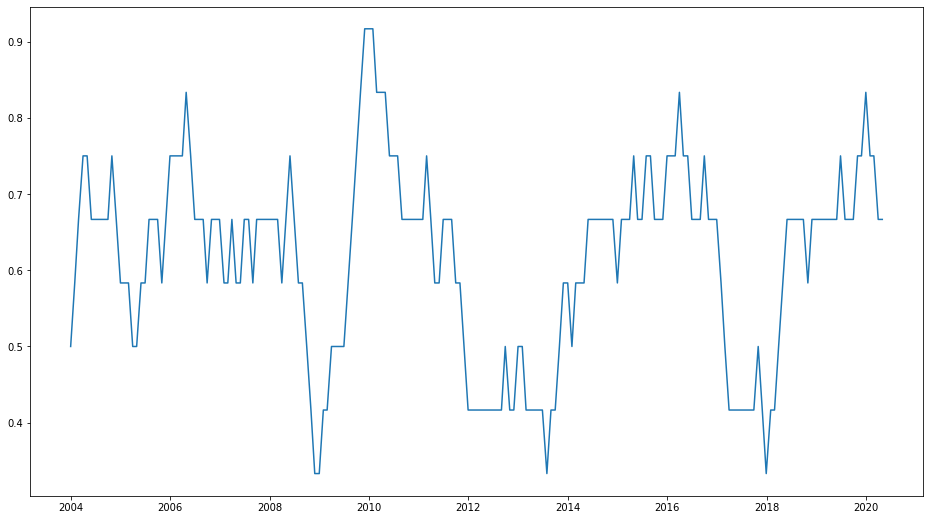

In [39]:
top_portfolio.plot_rolling_profitable_periods()

Также видно, что действительно портфель не обгоняет бенчмарк почти никогда.

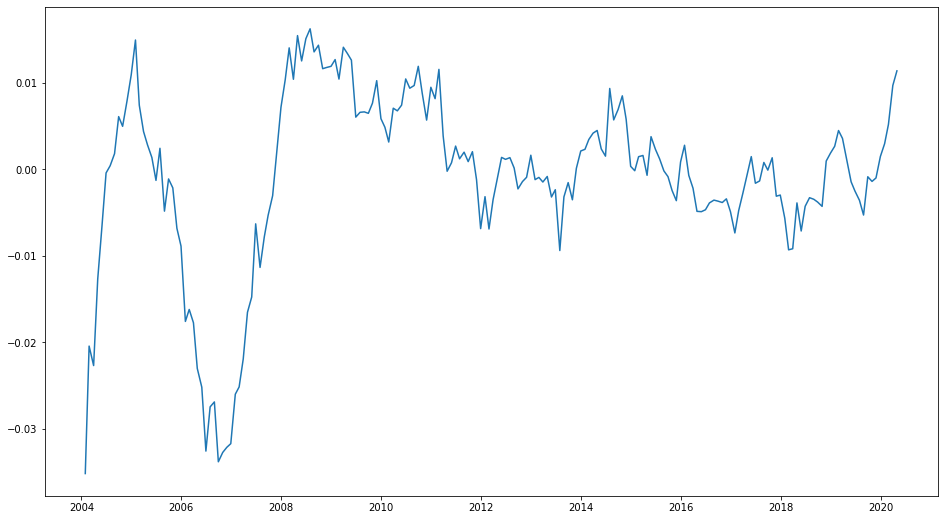

In [40]:
top_portfolio.plot_rolling_excessive_return()

Посмотрим также на summary-статистики.

In [44]:
pd.Series(top_portfolio.stats).round(2)

Alpha, %                   0.01
Alpha p-value              0.96
Beta                       0.95
Beta p-value               0.00
Sharpe Ratio               0.55
Mean Return, %             1.15
Excessive Return, %       -0.16
Total Return, %          521.62
Volatility, %              7.23
Benchmark Correlation      0.90
Profitable Periods, %     60.58
Maximum Drawdown, %      -94.62
dtype: float64

# Дополнительно: мультифакторы

Может не получиться обыграть рынок на основе только лишь 1 фактора, поэтому в библиотеке реализованы различные подходы к комбинированию факторов:
* weighting - просто взвешивание факторов
* intercept - пересечение выборов факторов
* nsort - отбор сначала по 1 фактору, из этого множества отбор по 2 фактору, из этого множества по 3 и т.д. ...

TS/CS не выделен в отдельный мультифактор, поскольку можно добиться того же самого эффекта, если отфильтровать по ts-фактору множество доступных акций.

Также существуют мультифакторы для фильтрации (просто последовательное фильтрование каждым из факторов) и взвешивания (последовательное взвешивание каждым из факторов).

### ! Важно: 
Мультифактор может содержать разнородные факторы (например, low_volatility и quality: от волатильности мы хотим наименьшее значение (bigger_better=False), а от quality - наибольшее (bigger_better=True)). 

В таком случае квантили для NSort и Intercept строятся относительно bigger_better: то есть если я хочу построить портфель на основе квантилей (0.8; 1), то это значит, что я беру (0.8, 1) по quality и (0, 0.2) по low_volatility (автоматически происходит "отзеркаливание" квантиля для фактора с bigger_better=False).

Если все факторы однородные (либо bigger_better=False для всех, либо bigger_better=True для всех), то портфель строится именно по тем квантилям, которые переданы.

Порядок передачи факторов также важен: для NSort мы сначала сортируем по 1 фактору, потом по 2 и т.д. (передавать можно сколько угодно факторов во все мультифакторы).

In [46]:
# отбирающие факторы
from pqr.factors import WeighMultiFactor, InterceptMultiFactor, NSortMultiFactor
# фильтрующий и взвешивающий мультифакторы
from pqr.factors import FilteringMultiFactor, WeightingMultiFactor

In [56]:
# подгрузим p/e для демонстрации
pe = pd.read_excel('~/notebooks/pqr/factors/PE.xlsx', index_col=0, parse_dates=True)

# заново корректируем все матрицы
prices, mcap, volume, pe = correct_matrices(prices, mcap, volume, pe)
# заменяем 0 на nan
pe = replace_with_nan(pe, to_replace=[0])[0]

In [57]:
# перейдем к фактору стоимости
value = PickingFactor(
    data=pe,
    dynamic=False,
    bigger_better=False,
    name='value_p/e'
)

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",-0.07,-0.05,-0.09
Alpha p-value,0.83,0.87,0.50
Beta,1.08,0.96,0.98
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.48,0.48,0.53
"Mean Return, %",1.24,1.10,1.09
"Excessive Return, %",-0.07,-0.20,-0.21
"Total Return, %",456.94,412.27,458.26
"Volatility, %",8.93,7.88,7.08
Benchmark Correlation,0.84,0.84,0.95


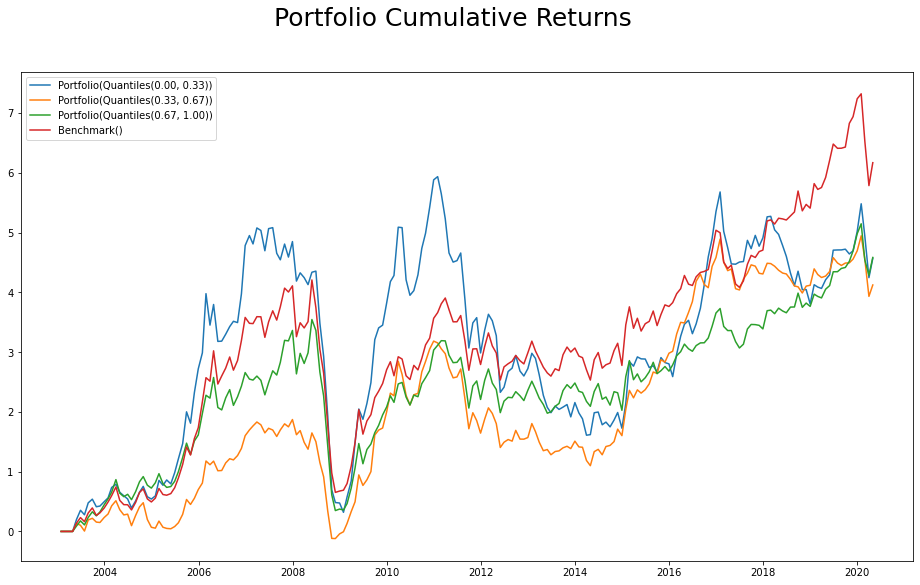

In [61]:
weigh = WeighMultiFactor(
    factors=[size, value],
    weights=[0.1, 0.9],
    name='weigh_size+value'
)

fm_weigh = FactorModel(3, 0, 3)
fm_weigh.fit(
    prices=prices,
    picking_factor=weigh,
    filtering_factor=liquidity,
    benchmark=benchmark
)
fm_weigh.compare_portfolios()

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",0.02,-0.76,-0.20
Alpha p-value,0.97,0.23,0.60
Beta,1.02,1.02,1.08
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.45,0.15,0.41
"Mean Return, %",1.24,0.48,1.10
"Excessive Return, %",-0.06,-0.82,-0.20
"Total Return, %",421.24,-46.68,277.56
"Volatility, %",9.49,11.37,9.21
Benchmark Correlation,0.74,0.62,0.81


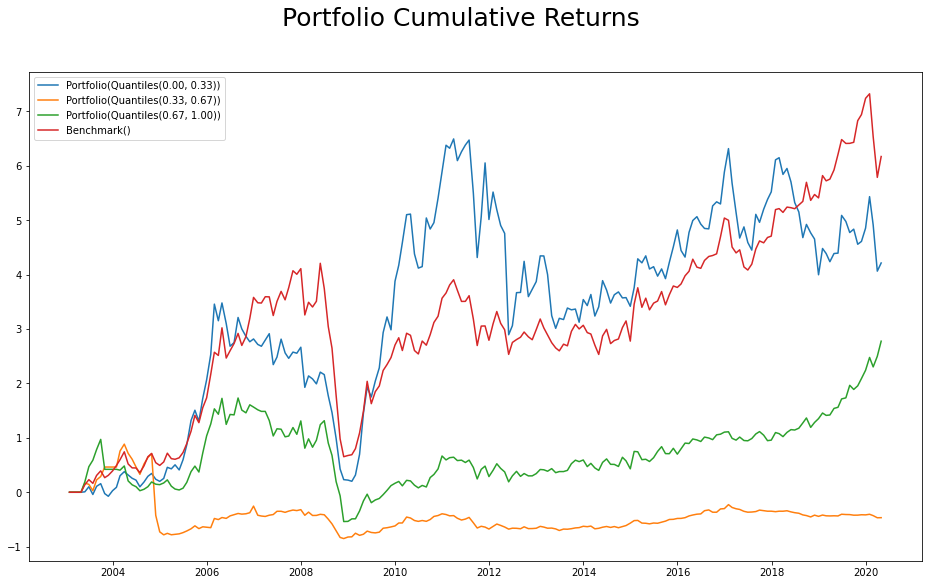

In [63]:
intercept = InterceptMultiFactor(
    factors=[size, value],
    name='intercept_size+value'
)

fm_intercept = FactorModel(3, 0, 3)
fm_intercept.fit(
    prices=prices,
    picking_factor=intercept,
    filtering_factor=liquidity,
    benchmark=benchmark
)
fm_intercept.compare_portfolios()

Посмотрим на количество различных бумаг в портфеле и на то, какие бумаги были в нем наиболее часто.

<AxesSubplot:>

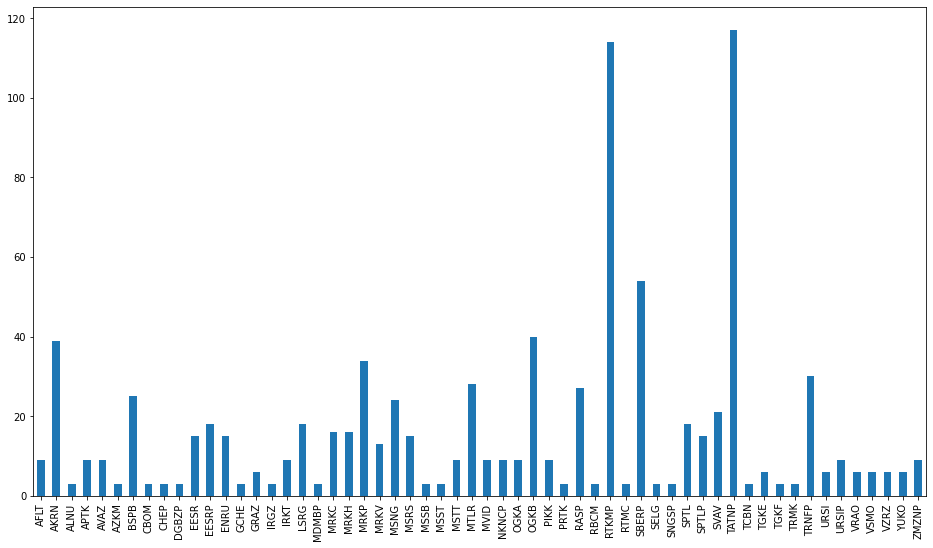

In [69]:
picks_intercept = fm_intercept.portfolios[0].positions.sum()
picks_intercept[picks_intercept != 0].plot.bar()

<AxesSubplot:xlabel='Date'>

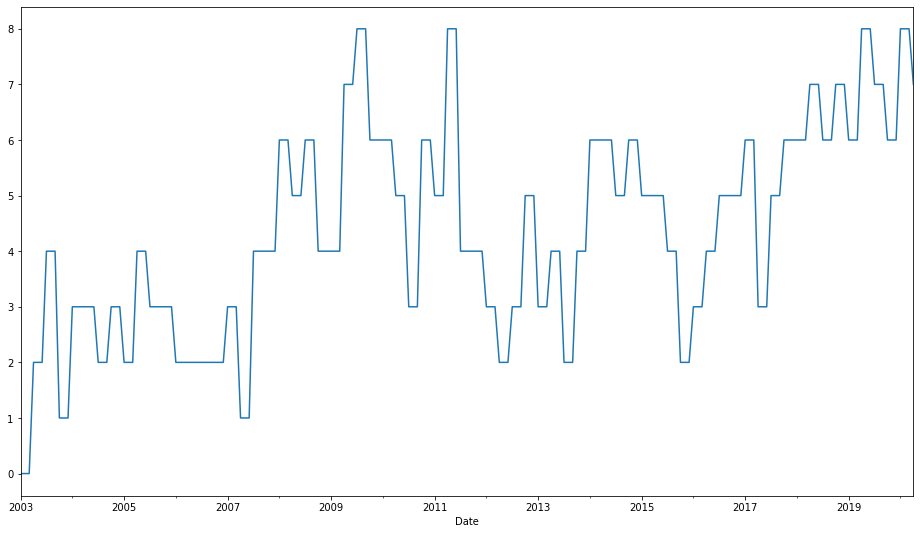

In [70]:
fm_intercept.portfolios[0].positions.sum(axis=1).plot()

,"Portfolio(Quantiles(0.00, 0.33))","Portfolio(Quantiles(0.33, 0.67))","Portfolio(Quantiles(0.67, 1.00))"
"Alpha, %",0.14,-0.66,-0.21
Alpha p-value,0.76,0.12,0.47
Beta,1.04,0.91,1.04
Beta p-value,0.00,0.00,0.00
Sharpe Ratio,0.50,0.18,0.44
"Mean Return, %",1.39,0.45,1.06
"Excessive Return, %",0.09,-0.85,-0.25
"Total Return, %",603.27,12.59,319.33
"Volatility, %",9.68,8.67,8.34
Benchmark Correlation,0.75,0.73,0.87


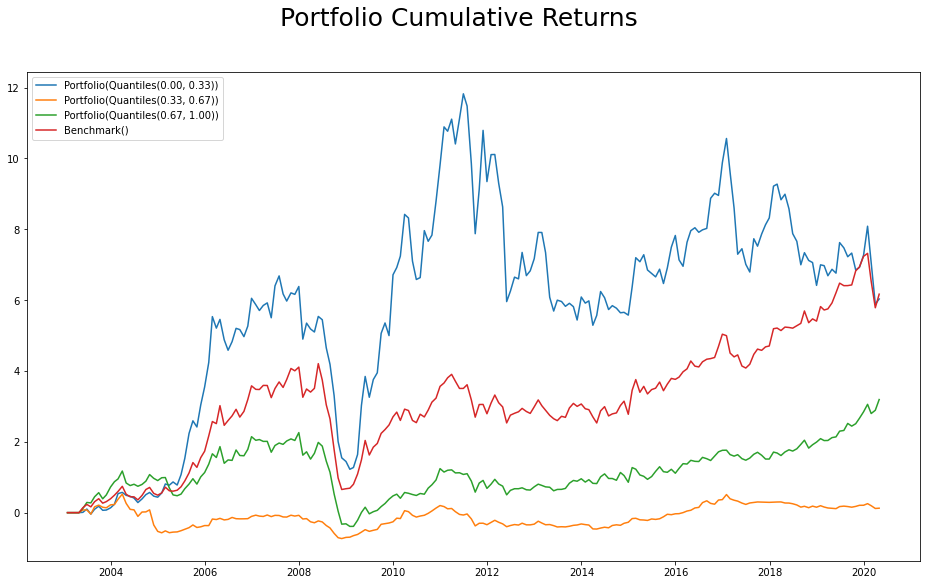

In [64]:
nsort = NSortMultiFactor(
    factors=[size, value],
    name='nsort_size+value'
)

fm_nsort = FactorModel(3, 0, 3)
fm_nsort.fit(
    prices=prices,
    picking_factor=nsort,
    filtering_factor=liquidity,
    benchmark=benchmark
)
fm_nsort.compare_portfolios()

<AxesSubplot:>

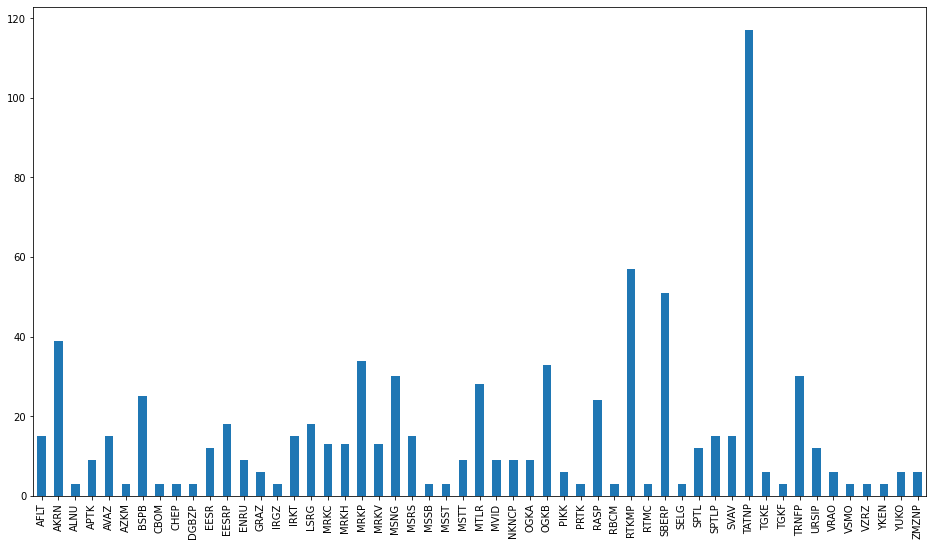

In [65]:
picks_nsort = fm_nsort.portfolios[0].positions.sum()
picks_nsort[picks_nsort != 0].plot.bar()

<AxesSubplot:xlabel='Date'>

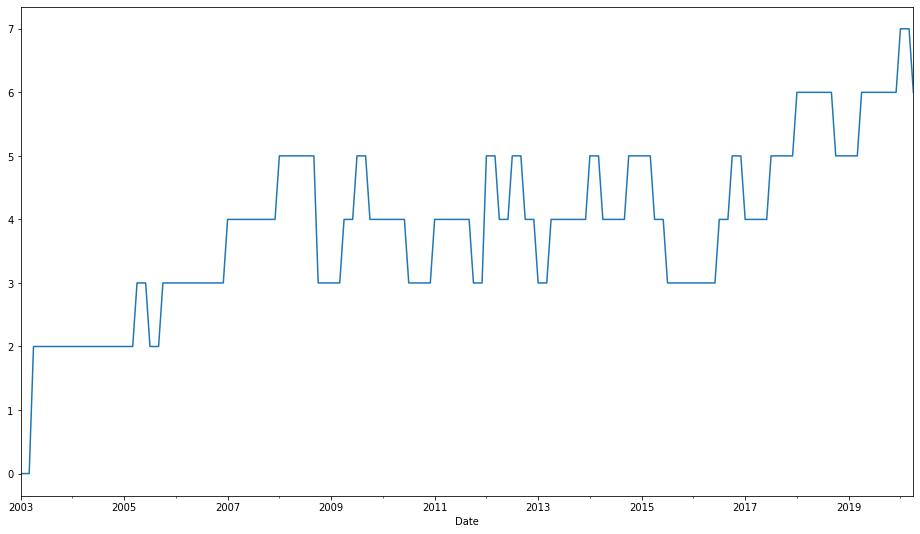

In [68]:
fm_nsort.portfolios[0].positions.sum(axis=1).plot()